In [1]:
from covid_analysis import *

%matplotlib inline
sns.set(style="whitegrid")
FIGSIZE = [12, 8]

# México

In [2]:
estados_analisis = ["Ciudad de México", "Nuevo León", "Jalisco", "Queretaro"]
estados = load_mariorz()
mexico = {}
for ds_name, ds in estados.items():
    mexico[ds_name] = pd.DataFrame({'Mexico': ds.sum(axis=1)})

## Resumen

### Fecha de Actualización:

In [3]:
mexico['confirmados'].index[-1].strftime("%d-%m-%Y")

'04-06-2020'

### Confirmados

In [4]:
sum(mexico['confirmados'].iloc[-1])

105680

### Nuevos Confirmados

In [5]:
sum(mexico['daily_confirmados'].iloc[-1])

4442

### Fallecimientos

In [6]:
sum(mexico['muertos'].iloc[-1])

12545

### Nuevos Fallecimientos

In [7]:
sum(mexico['daily_muertos'].iloc[-1])

817

## Nacional

### México: Confirmados acumulados

,Mexico
Date,
2020-05-22,62527
2020-05-23,65856
2020-05-24,68620
2020-05-25,71105
2020-05-26,74560
2020-05-27,78023
2020-05-28,81400
2020-05-29,84627
2020-05-30,87512


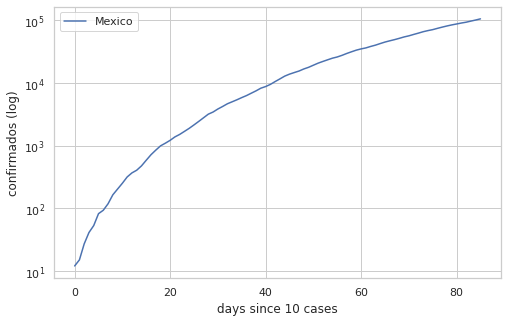

In [8]:
analysis(mexico, ["Mexico"], "confirmados", log=True, smooth=False, since=10)

### México: Confirmados diarios

,Mexico
Date,
2020-05-22,2960
2020-05-23,3329
2020-05-24,2764
2020-05-25,2485
2020-05-26,3455
2020-05-27,3463
2020-05-28,3377
2020-05-29,3227
2020-05-30,2885


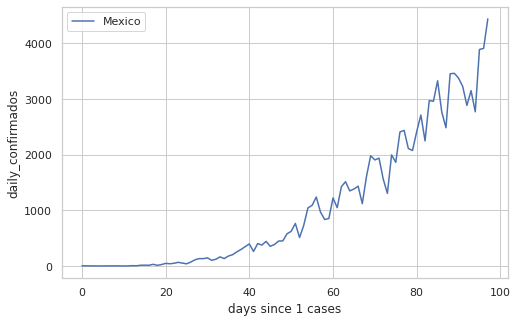

In [9]:
analysis(mexico, ["Mexico"], "daily_confirmados", since=1, smooth=False, log=False)

### México: Fallecimientos acumulados

,Mexico
Date,
2020-05-22,6989
2020-05-23,7179
2020-05-24,7394
2020-05-25,7633
2020-05-26,8134
2020-05-27,8597
2020-05-28,9044
2020-05-29,9415
2020-05-30,9779


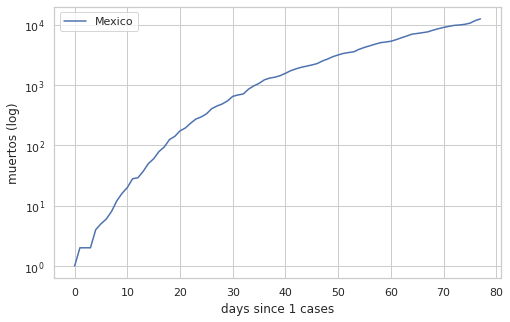

In [10]:
analysis(mexico, ["Mexico"], "muertos", since=1, smooth=False, log=True)

### México: Fallecimientos diarios

,Mexico
Date,
2020-05-22,479
2020-05-23,190
2020-05-24,215
2020-05-25,239
2020-05-26,501
2020-05-27,463
2020-05-28,447
2020-05-29,371
2020-05-30,364


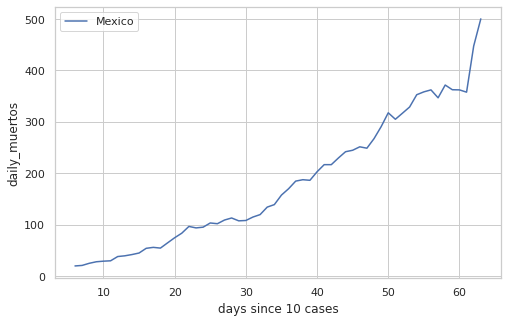

In [41]:
analysis(mexico, ["Mexico"], "daily_muertos", since=10, smooth=True, smooth_window=7, log=False)

### México: Pruebas reportadas por día, acumuladas

,Mexico
Date,
2020-05-22,210070
2020-05-23,215656
2020-05-24,219164
2020-05-25,225650
2020-05-26,235129
2020-05-27,244858
2020-05-28,254794
2020-05-29,264026
2020-05-30,270992


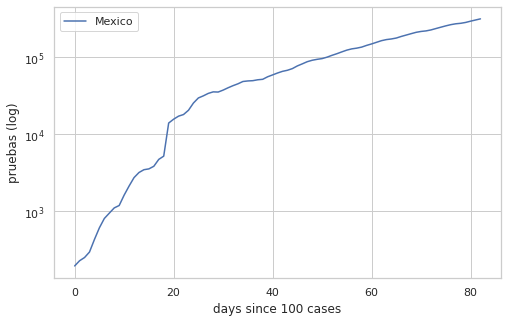

In [12]:
mexico['pruebas'] = mexico['confirmados'].add(mexico['probables']).add(mexico['descartados'])
analysis(mexico, ['Mexico'], 'pruebas', smooth=False, log=True)

### México: Pruebas reportadas por día

,Mexico
Date,
2020-05-22,8232
2020-05-23,5586
2020-05-24,3508
2020-05-25,6486
2020-05-26,9479
2020-05-27,9729
2020-05-28,9936
2020-05-29,9232
2020-05-30,6966


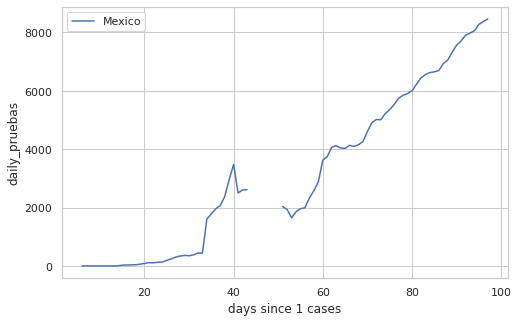

In [42]:
mexico['daily_pruebas'] = mexico['daily_confirmados'].add(mexico['daily_probables']).add(mexico['daily_descartados'])
analysis(mexico, ["Mexico"], "daily_pruebas", since=1, smooth=True, smooth_window=7, log=False)#, show_last_days=50)

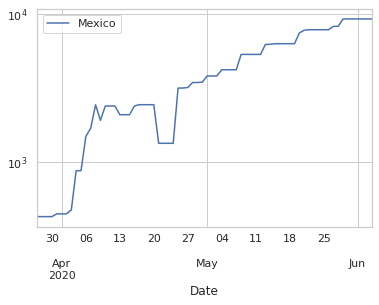

In [14]:
mexico['daily_pruebas'].rolling(window=7).median()[-70:].plot(logy=True)

### México: Positividad 
Proporción de confirmados del total de pruebas reportadas por día

,Mexico
Date,
2020-05-22,0.359572
2020-05-23,0.595954
2020-05-24,0.787913
2020-05-25,0.383133
2020-05-26,0.364490
2020-05-27,0.355946
2020-05-28,0.339875
2020-05-29,0.349545
2020-05-30,0.414154


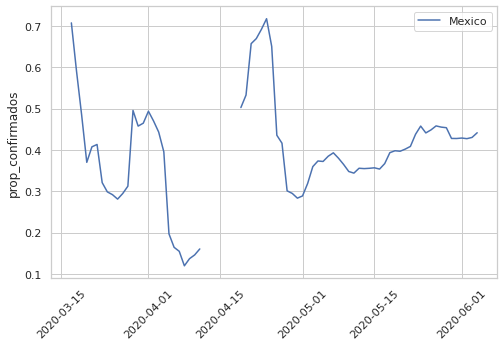

In [15]:
mexico['prop_confirmados'] = mexico['daily_confirmados'] / mexico['daily_pruebas']
analysis(mexico, ['Mexico'], 'prop_confirmados', smooth=True, log=False, since=None)

,Mexico
Date,
2020-05-22,0.297648
2020-05-23,0.305375
2020-05-24,0.313099
2020-05-25,0.315112
2020-05-26,0.317103
2020-05-27,0.318646
2020-05-28,0.319474
2020-05-29,0.320525
2020-05-30,0.322932


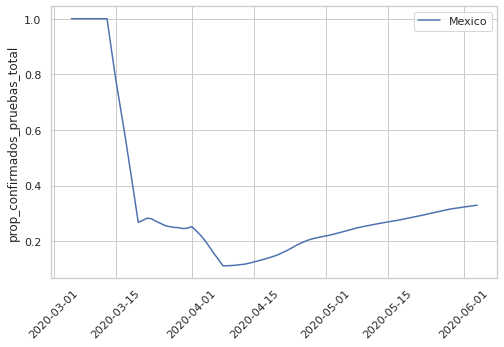

In [16]:
mexico['prop_confirmados_pruebas_total'] = mexico['confirmados'] / mexico['pruebas']
analysis(mexico, ['Mexico'], 'prop_confirmados_pruebas_total', smooth=True, smooth_window=7, log=False, since=None)

### México: proporción de fallecimientos a pruebas, acumulados

,Mexico
Date,
2020-05-22,0.033270
2020-05-23,0.033289
2020-05-24,0.033737
2020-05-25,0.033827
2020-05-26,0.034594
2020-05-27,0.035110
2020-05-28,0.035495
2020-05-29,0.035659
2020-05-30,0.036086


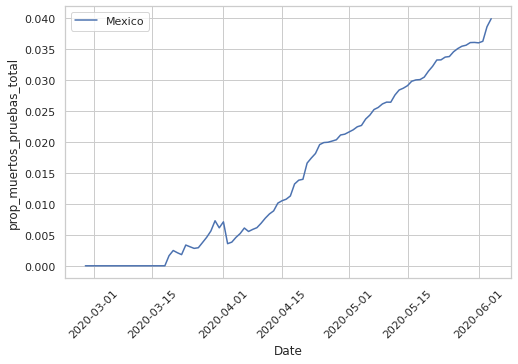

In [17]:
mexico['prop_muertos_pruebas_total'] = mexico['muertos'] / mexico['pruebas']
analysis(mexico, ['Mexico'], 'prop_muertos_pruebas_total', smooth=False, log=False, since=None)

,Mexico
Date,
2020-05-22,0.111776
2020-05-23,0.109011
2020-05-24,0.107753
2020-05-25,0.107348
2020-05-26,0.109093
2020-05-27,0.110185
2020-05-28,0.111106
2020-05-29,0.111253
2020-05-30,0.111745


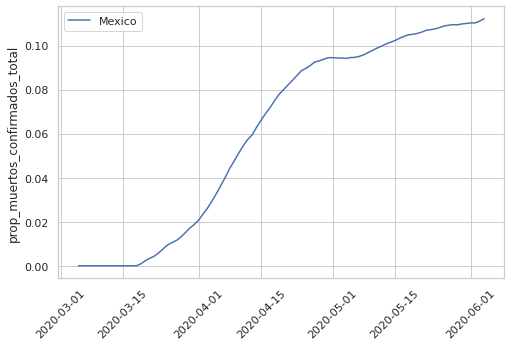

In [18]:
mexico['prop_muertos_confirmados_total'] = mexico['muertos'] / mexico['confirmados']
analysis(mexico, ['Mexico'], 'prop_muertos_confirmados_total', smooth=True, smooth_window=7, log=False, since=None)

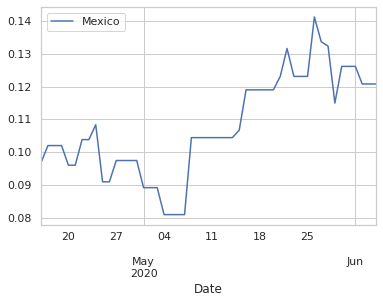

In [19]:
mexico['prop_muertos_confirmados_daily'] = mexico['daily_muertos'] / mexico['daily_confirmados']
mexico['prop_muertos_confirmados_daily'].rolling(window=7).median()[-50:].plot()

## Estados

### Estados: Confirmados acumulados

Estado,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-22,21182,1095,1108,675
2020-05-23,22675,1125,1145,712
2020-05-24,23618,1154,1195,732
2020-05-25,24286,1174,1253,755
2020-05-26,25171,1227,1312,788
2020-05-27,26137,1293,1370,835
2020-05-28,27319,1329,1452,867
2020-05-29,28397,1366,1546,889
2020-05-30,29205,1377,1686,937


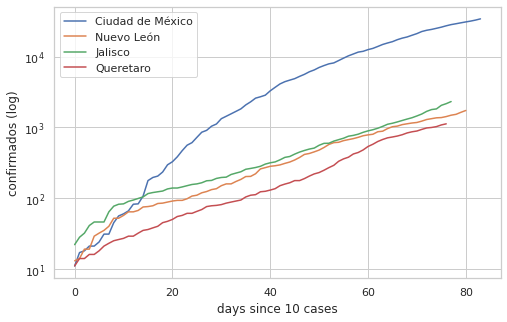

In [44]:
analysis(estados, estados_analisis, "confirmados", since=10, log=True, smooth=False)

### Estados: Confirmados diarios

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-22,1106,52,74,43
2020-05-23,1493,30,37,37
2020-05-24,943,29,50,20
2020-05-25,668,20,58,23
2020-05-26,885,53,59,33
2020-05-27,966,66,58,47
2020-05-28,1182,36,82,32
2020-05-29,1078,37,94,22
2020-05-30,808,11,140,48


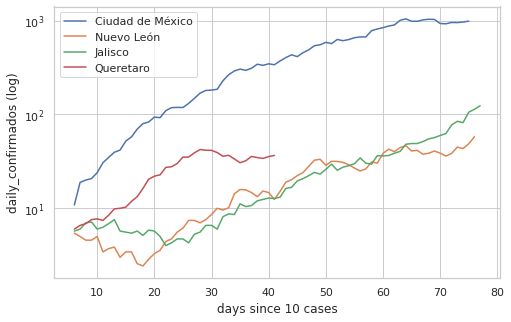

In [21]:
analysis(estados, estados_analisis, "daily_confirmados", since=10, log=True, smooth=True, smooth_window=7)

### Estados: Fallecimientos diarios 

,Nuevo León,Jalisco,Queretaro
Date,,,
2020-05-22,4,6,8
2020-05-23,0,0,0
2020-05-24,0,5,6
2020-05-25,5,9,3
2020-05-26,4,9,6
2020-05-27,5,3,5
2020-05-28,4,5,6
2020-05-29,5,3,5
2020-05-30,2,3,4


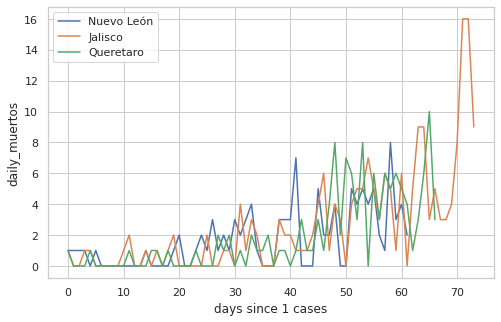

In [50]:
analysis(estados, estados_analisis[1:], "daily_muertos", since=1, log=False, smooth=False)

### Estados: Trayectorias

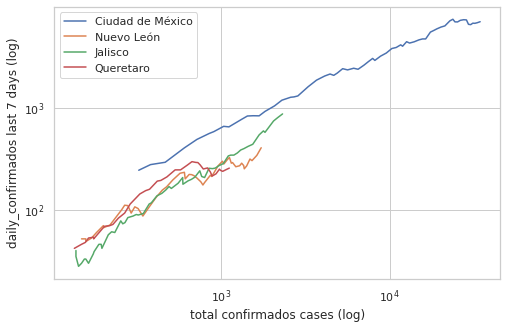

In [51]:
trajectories(estados, estados_analisis, 'confirmados', since=100, window=7)

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-22,57721,11299,10304,2135
2020-05-23,58937,11684,10547,2180
2020-05-24,59666,11930,10681,2223
2020-05-25,61617,12216,10866,2261
2020-05-26,64183,12648,11282,2359
2020-05-27,66890,13193,11635,2480
2020-05-28,69525,13784,12084,2600
2020-05-29,71709,14455,12484,2676
2020-05-30,73140,14918,12856,2749


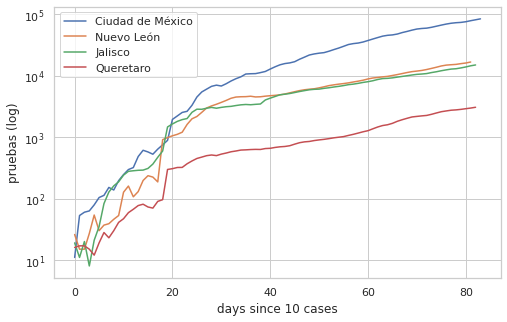

In [24]:
pruebas = {}
for estado in estados['confirmados'].columns:
    pruebas[estado] = estados['confirmados'][estado] + estados['probables'][estado] + estados['descartados'][estado]
estados['pruebas'] = pd.DataFrame(pruebas)
estados['daily_pruebas'] = get_new_per_day(estados['pruebas'])
    
analysis(estados, estados_analisis, "pruebas", since=10, log=True, smooth=False)
#pruebas[-30:].plot(logy=True)

,Ciudad de México,Nuevo León,Jalisco,Queretaro
Date,,,,
2020-05-22,2311,430,281,104
2020-05-23,1216,385,243,45
2020-05-24,729,246,134,43
2020-05-25,1951,286,185,38
2020-05-26,2566,432,416,98
2020-05-27,2707,545,353,121
2020-05-28,2635,591,449,120
2020-05-29,2184,671,400,76
2020-05-30,1431,463,372,73


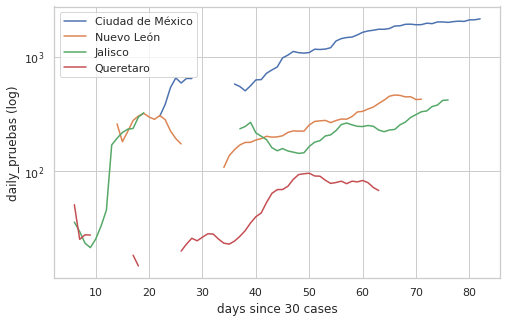

In [25]:
analysis(estados, estados_analisis, "daily_pruebas", since=30, log=True, smooth=True, smooth_window=7)

# Mundo

In [26]:
analysis_countries = ["Mexico", "US", "Spain", "Italy", "Australia", "Korea, South", "Brazil", "United Kingdom"]
world = load_johns_hopkins()

## Mundo: Confirmados acumulados

Country/Region,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-22,62527,1600937,234824,228658,7099,11165,330890,255544
2020-05-23,65856,1622612,235290,229327,7114,11190,347398,258504
2020-05-24,68620,1643246,235772,229858,7114,11206,363211,260916
2020-05-25,71105,1662302,235400,230158,7126,11225,374898,262547
2020-05-26,74560,1680913,236259,230555,7139,11265,391222,266599
2020-05-27,78023,1699176,236259,231139,7150,11344,411821,268619
2020-05-28,81400,1721753,237906,231732,7165,11402,438238,270508
2020-05-29,84627,1746019,238564,232248,7184,11441,465166,272607
2020-05-30,87512,1770165,239228,232664,7192,11468,498440,274219


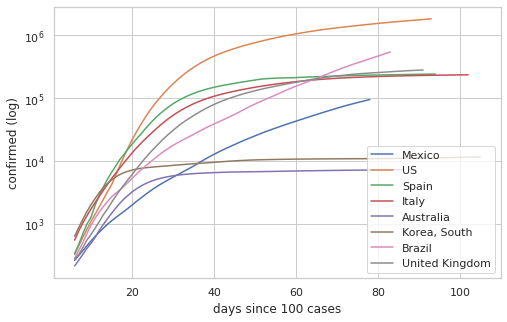

In [27]:
analysis(world, analysis_countries, "confirmed")

## Mundo: Confirmados diarios

,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-22,2960,23790,1787,652,4,23,20803,3298
2020-05-23,3329,21675,466,669,15,25,16508,2960
2020-05-24,2764,20634,482,531,0,16,15813,2412
2020-05-25,2485,19056,-372,300,12,19,11687,1631
2020-05-26,3455,18611,859,397,13,40,16324,4052
2020-05-27,3463,18263,0,584,11,79,20599,2020
2020-05-28,3377,22577,1647,593,15,58,26417,1889
2020-05-29,3227,24266,658,516,19,39,26928,2099
2020-05-30,2885,24146,664,416,8,27,33274,1612


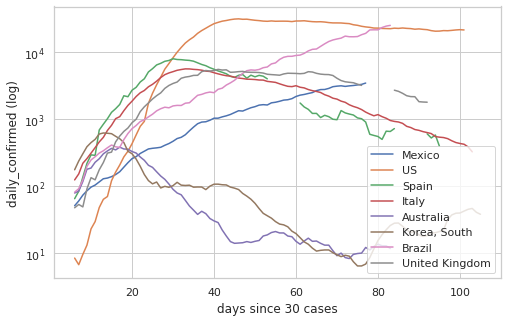

In [28]:
analysis(world, analysis_countries, "daily_confirmed", since=30)

## Mundo: Fallecimientos acumulados

Country/Region,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-22,6989,95978,28628,32616,101,266,21048,36475
2020-05-23,7179,97086,28678,32735,102,266,22013,36757
2020-05-24,7394,97719,28752,32785,102,267,22666,36875
2020-05-25,7633,98219,26834,32877,102,269,23473,36996
2020-05-26,8134,98912,27117,32955,103,269,24512,37130
2020-05-27,8597,100417,27117,33072,103,269,25598,37542
2020-05-28,9044,101616,27119,33142,103,269,26754,37919
2020-05-29,9415,102809,27121,33229,103,269,27878,38243
2020-05-30,9779,103776,27125,33340,103,270,28834,38458


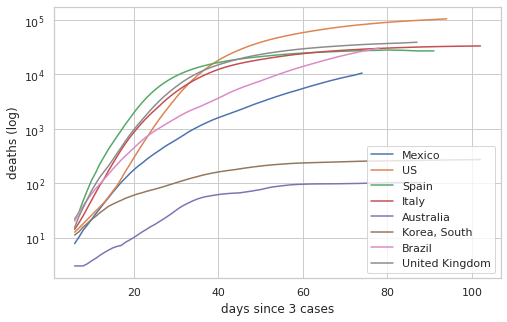

In [29]:
analysis(world, analysis_countries, "deaths", since=3)

## Mundo: Fallecimientos diarios

,Mexico,US,Spain,Italy,Australia,"Korea, South",Brazil,United Kingdom
Date,,,,,,,,
2020-05-22,479,1276,688,130,0,2,1001,351
2020-05-23,190,1108,50,119,1,0,965,282
2020-05-24,215,633,74,50,0,1,653,118
2020-05-25,239,500,-1918,92,0,2,807,121
2020-05-26,501,693,283,78,1,0,1039,134
2020-05-27,463,1505,0,117,0,0,1086,412
2020-05-28,447,1199,2,70,0,0,1156,377
2020-05-29,371,1193,2,87,0,0,1124,324
2020-05-30,364,967,4,111,0,1,956,215


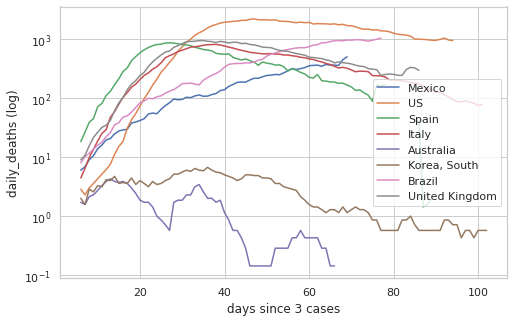

In [30]:
analysis(world, analysis_countries, "daily_deaths", since=3)

## Mundo: Trayectorias de casos confirmados

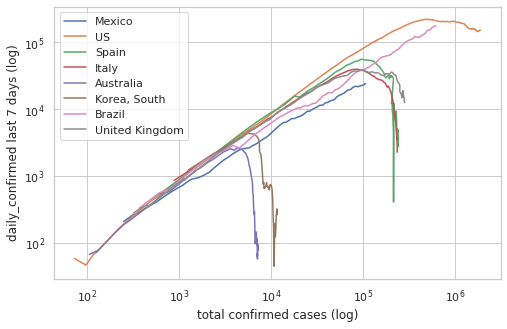

In [55]:
trajectories(world, analysis_countries, 'confirmed', since=50, window=7)

## Querétaro

Estado,Ciudad de México,Queretaro
Date,,
2020-05-22,21182,675
2020-05-23,22675,712
2020-05-24,23618,732
2020-05-25,24286,755
2020-05-26,25171,788
2020-05-27,26137,835
2020-05-28,27319,867
2020-05-29,28397,889
2020-05-30,29205,937


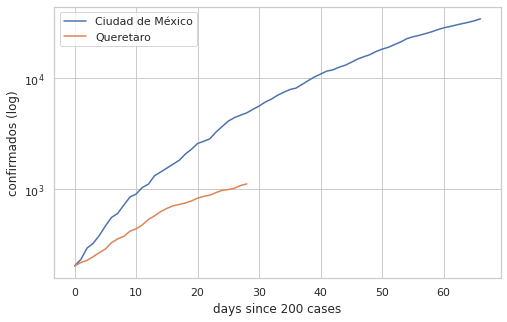

In [56]:
analysis(estados, ["Ciudad de México", "Queretaro"], "confirmados", since=200, log=True, smooth=False, smooth_window=7)

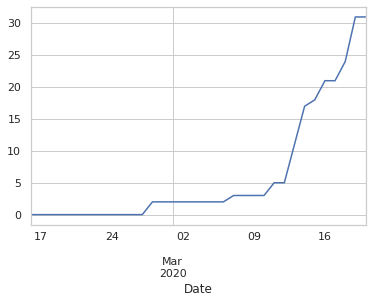

In [33]:
estados['confirmados']['Ciudad de México']['2020-02-16':'2020-03-20'].rolling(window=1).sum().plot()

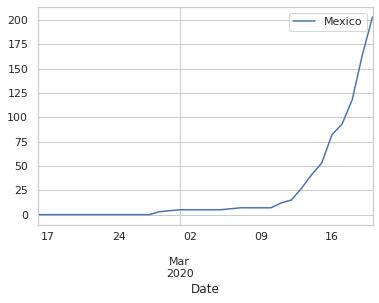

In [34]:
mexico['confirmados']['2020-02-16':'2020-03-20'].plot()

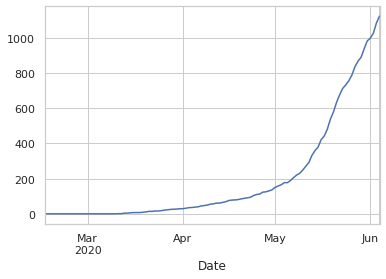

In [35]:
estados['confirmados']['Queretaro']['2020-02-16':].plot()

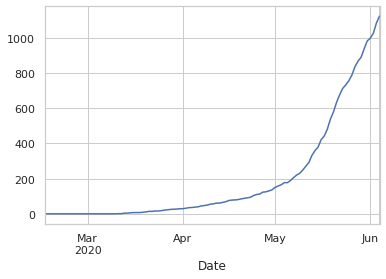

In [36]:
estados['confirmados']['Queretaro']['2020-02-16':].plot()

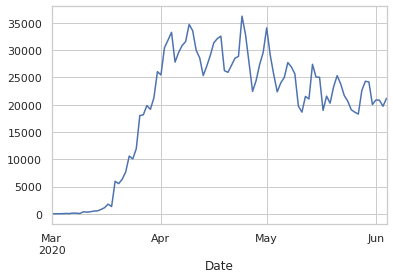

In [37]:
us = world['daily_confirmed']['US']['2020-03-01':]
us.plot()

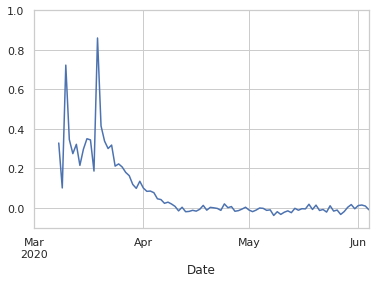

In [38]:
us.rolling(window=7).mean().pct_change().plot(ylim=(-.1,1))

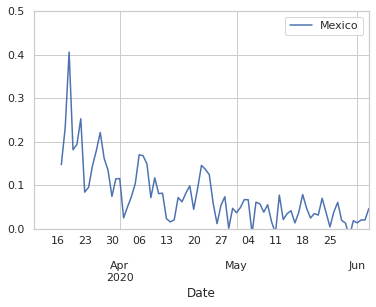

In [39]:
mexico['daily_confirmados']['2020-03-10':].rolling(window=7).mean().pct_change().plot(ylim=(0,0.5))

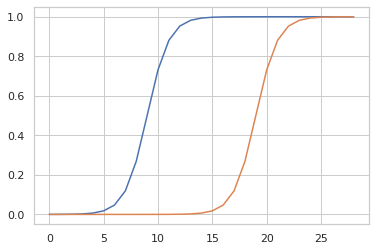

0    0.000123
1    0.000335
2    0.000911
3    0.002473
4    0.006693
dtype: float64


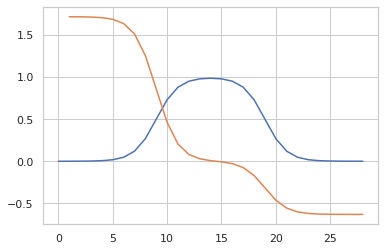

In [40]:
def logistic(x, b=0, k=1):
    L = 1
    d = 1 + np.exp(-k * (x - b))
    return L/d

def updown(x):
    return logistic(x, b=10, k=1) - logistic(x, b=20, k=0.5)

l1 = pd.Series([logistic(x, b=10, k=1) for x in range(1,30)])
l2 = pd.Series([logistic(x, b=20, k=1) for x in range(1,30)])
l1.plot()
l2.plot()
plt.show()
a = l1 - l2
print(a.head())
a.plot()
b = a.pct_change()
b.plot()

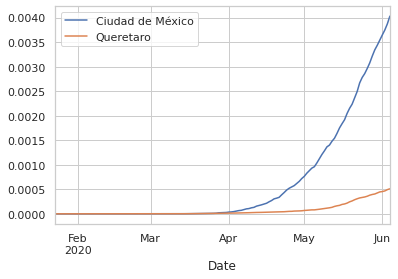

In [66]:
cdmx_pm = estados['confirmados']['Ciudad de México'] / 8500000
qro_pm = estados['confirmados']['Queretaro'] / 2200000

cdmx_pm.plot()
qro_pm.plot()
plt.legend()

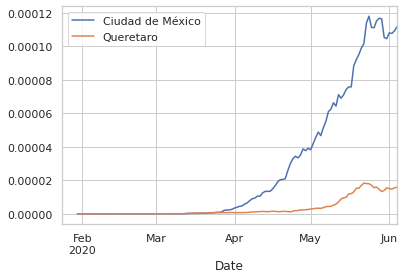

In [67]:
cdmx_pm = estados['daily_confirmados']['Ciudad de México'] / 8855000
qro_pm = estados['daily_confirmados']['Queretaro'] / 2300000

cdmx_pm.rolling(window=7).mean().plot()
qro_pm.rolling(window=7).mean().plot()
plt.legend()